# Introduction
# Getting Ready for This Homework
# How to Use the COCO Annotations
# Programming Tasks

## Creating Your Own Object Localization Dataset

In [1]:
from pycocotools.coco import COCO

trainAnnFile = "../coco2014/annotations_trainval/instances_train2014.json"
cocoTrain = COCO(trainAnnFile)
valAnnFile = "../coco2014/annotations_trainval/instances_val2014.json"
cocoVal = COCO(valAnnFile)

loading annotations into memory...
Done (t=10.17s)
creating index...
index created!
loading annotations into memory...
Done (t=5.45s)
creating index...
index created!


In [2]:
import os
import json
from PIL import Image

class_list = ["pizza", "bus", "cat"]

def generate_dataset(coco, inPath, outPath, annFileName):
    coco_labels_inverse = {}
    catIds = coco.getCatIds(catNms=class_list)
    categories = coco.loadCats(catIds)

    # like this because getCatIds doesn't return them in same order as passed in
    coco_labels_inverse = dict()
    for idx , in_class in enumerate(class_list):
        for c in categories:
            if c ['name'] == in_class:
                coco_labels_inverse[c['id']] = idx

    imgIds = set()
    for catId in catIds:
        imgIds |= set(coco.getImgIds(catIds=catId))
        
    imgs = coco.loadImgs(imgIds)    
    annotations = list()
    for img in imgs:
        # need catIds, filters out annotations that don't have one of the categories
        annIds = coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=False)
        anns = coco.loadAnns(annIds)
        anns.sort(key=lambda x: x['area'])
        anns.reverse()
        ann = anns[0]
        if ann['area'] < 40000: continue

        pic = Image.open(os.path.join(inPath, img["file_name"]))
        newPic = pic.resize((256,256))
        filename = '{:05}.jpg'.format(len(annotations))
        
        bbox = ann["bbox"]
        xs = newPic.size[0] / pic.size[0]
        ys = newPic.size[1] / pic.size[1]
        newBbox = [int(bbox[0]*xs), int(bbox[1]*ys), 
                   int(bbox[2]*xs), int(bbox[3]*ys)]
        
        newPic.save(os.path.join(outPath, filename))   
        annotation = {
            "file_name": filename,
            "category": coco_labels_inverse[ann["category_id"]],
            "bbox": newBbox
        }
        annotations.append(annotation)
        
    with open(annFileName, "w") as file:
        file.write(json.dumps(annotations, indent=4))
    print("num images in", annFileName, ":", len(annotations))

# generate_dataset(cocoTrain, "../coco2014/train/", "dataset/train/", "dataset/train_ann.json")
print("num images in dataset/train_ann.json : 3952")
# generate_dataset(cocoVal, "../coco2014/val/", "dataset/val/", "dataset/val_ann.json")
print("num images in dataset/val_ann.json : 2058")

num images in dataset/train_ann.json : 3952
num images in dataset/val_ann.json : 2058


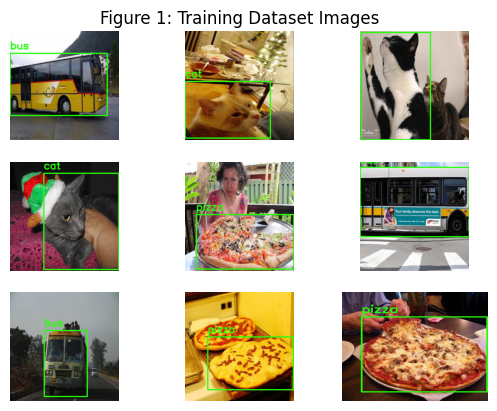

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

with open("dataset/train_ann.json", "r") as file:
    anns = json.loads(file.read())

plt.figure()
fignum = 0
counts = {i: 0 for i, _ in enumerate(class_list)}

for ann in anns:
    if counts[ann["category"]] == 3: continue
    counts[ann["category"]] += 1
    fignum += 1
    
    pic = Image.open(os.path.join("dataset/train/", ann["file_name"]))
    image = np.array(pic, dtype=np.uint8)

    [x, y, w, h] = ann["bbox"]
    image = cv2.rectangle(image, (x,y), (x+w, y+h), (36,355,12), 2)
    image = cv2.putText(image, class_list[ann["category"]], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
    
    ax = plt.subplot(3,3,fignum)
    plt.imshow(image)
    ax.set_axis_off()
    
    if fignum == 2:
        ax.set_title("Figure 1: Training Dataset Images")
    if fignum > 9:
        break

plt.axis("tight")
plt.show()

## Building Your Deep Neural Network

In [4]:
import torch
from torch import nn

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        # about inplace https://discuss.pytorch.org/t/when-inplace-operation-are-allowed-and-when-not/169583/2
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = out + identity
        return self.relu(out)
        

class HW5Net(nn.Module):
    """ Resnet - based encoder that consists of a few
    downsampling + several Resnet blocks as the backbone
    and two prediction heads .
    """
    def __init__(self, input_nc, ngf=8, n_blocks=4):
        """
        Parameters :
            input_nc (int)    -- the number of channels in input images
            ngf (int)         -- the number of filters in the first conv layer
            n_blocks (int)    -- the number of ResNet blocks
        """
        assert(n_blocks >= 0)
        super().__init__()
        # The first conv layer
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]        # size batchxngf,256x256
        # Add downsampling layers
        n_downsampling = 4
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size=3, stride=2, padding=1),
                      nn.BatchNorm2d(ngf*mult*2),
                      nn.ReLU(True)]
            # h,w go from 256->128->64->32->16
            # c go from ngf=8->16->32->64->128
        
        # Add your own ResNet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResBlock(ngf*mult, ngf*mult)]
        self.model = nn.Sequential(*model)
        
        # The classification head
        class_head = [
            ResBlock(ngf*mult, ngf*mult),
            nn.Conv2d(ngf*mult, ngf*mult, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(ngf*mult),
            nn.ReLU(inplace=True),
        ]
        self.class_head = nn.Sequential(*class_head)
        class_head_linear = [
            nn.Linear(ngf*mult*8*8, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3)
        ]
        self.class_head_linear = nn.Sequential(*class_head_linear)
        
        # The bounding box regression head
        bbox_head = [
            ResBlock(ngf*mult, ngf*mult),
            nn.Conv2d(ngf*mult, ngf*mult, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(ngf*mult),
            nn.ReLU(inplace=True),
        ]
        self.bbox_head = nn.Sequential(*bbox_head)
        bbox_head_linear = [
            nn.Linear(ngf*mult*8*8, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 4)
        ]
        self.bbox_head_linear = nn.Sequential(*bbox_head_linear)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        ft = self.model(x)
        
        classDis = self.class_head(ft)
        classDis = classDis.view(classDis.shape[0], -1)
        classDis = self.class_head_linear(classDis)
        
        bbox = self.bbox_head(ft)
        bbox = bbox.view(bbox.shape[0], -1)
        bbox = self.bbox_head_linear(bbox)
        return classDis, bbox
    
model = HW5Net(3)
num_layers = len(list(model.parameters()))
print("Total number of learnable layers:", num_layers)

Total number of learnable layers: 84


## Training and Evaluating Your Trained Network

In [5]:
import torchvision.transforms as tvt

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, ann_file, root_dir):
        super().__init__()
        with open(ann_file, "r") as file:
            self.anns = json.loads(file.read())
        self.root_dir = root_dir
        
        self.transform = tvt.Compose([
            tvt.ToTensor(),
            tvt.ColorJitter(brightness=.2, hue=.1)
        ])
                
    def __len__(self):
        return len(self.anns)
    
    def __getitem__(self, index):
        filename = self.anns[index]["file_name"]
        label = self.anns[index]["category"]
        bbox = self.anns[index]["bbox"]
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        bbox = (np.array(bbox) / 256).astype(np.float32)
        pic = Image.open(os.path.join(self.root_dir,filename)).convert("RGB")
        img = self.transform(pic)
        return (img, label, bbox)

In [6]:
trainDataset = MyDataset("dataset/train_ann.json", "dataset/train")
valDataset = MyDataset("dataset/val_ann.json", "dataset/val")

trainDataloader = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=8, num_workers=4)
valDataloader = torch.utils.data.DataLoader(valDataset, batch_size=14, num_workers=2)

In [41]:
import torchvision.ops as tops

def train_loop(net, dataloader, mseloss=True):
    net.train()
    losses = list()
    device = torch.device('cuda')
    net = net.to(device)
    classCriterion = torch.nn.CrossEntropyLoss()
    
    mseLossF = torch.nn.MSELoss()
    ciouLossF = lambda x, y: tops.complete_box_iou_loss(x, y, reduction="mean")
        
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9,0.99))
    epochs = 7
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels, bbox = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bbox = bbox.to(device)
            optimizer.zero_grad()
            
            outputs = net(inputs)
            classLoss = classCriterion(outputs[0], labels)
            if mseloss:
                bboxLoss = mseLossF(outputs[1], bbox)
            else:
                bboxLoss = ciouLossF(outputs[1], bbox)
                if epoch == 0:
                    bboxLoss = bboxLoss + mseLossF(outputs[1], bbox)
            loss = classLoss + bboxLoss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                losses.append(running_loss / 100)
                running_loss = 0
    return losses

In [8]:
modelMSE = HW5Net(3)
mseLoss = train_loop(modelMSE, trainDataloader, True)

In [42]:
modelCIoU = HW5Net(3)
ciouLoss = train_loop(modelCIoU, trainDataloader, False)

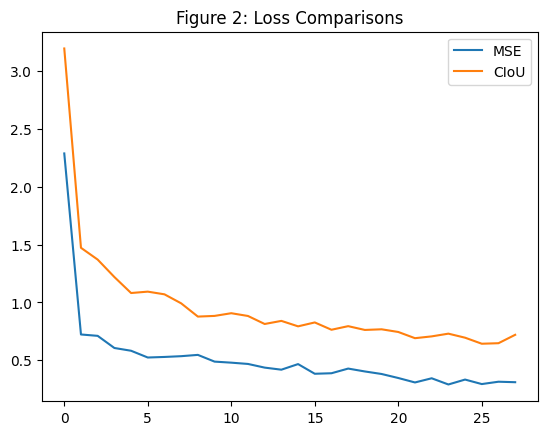

In [43]:
plt.plot(mseLoss)
plt.plot(ciouLoss)
plt.legend(["MSE", "CIoU"])
plt.title("Figure 2: Loss Comparisons")
plt.show()

In [11]:
def val_loop(net, dataset, dataloader, val_batch=14):
    net.eval()
    device = torch.device('cuda')
    net.to(device)
    labels = np.zeros(len(dataset))
    preds = np.zeros(len(dataset))
    ious = np.zeros(len(dataset))
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, lbls, bboxes = data
            imgs = imgs.to(device)
            predictions = net(imgs)
            classPreds = np.argmax(predictions[0].cpu().numpy(), axis=1)
            preds[(i*val_batch):(i*val_batch+val_batch)] = classPreds
            labels[(i*val_batch):(i*val_batch+val_batch)] = lbls.numpy()
            # if rescale_bbox: bboxes = bboxes * 256
            ious[(i*val_batch):(i*val_batch+val_batch)] = torch.diagonal(tops.box_iou(predictions[1].cpu(), bboxes)).numpy()
    return preds, labels, ious

In [12]:
msePred, mseLabels, mseIous = val_loop(modelMSE, valDataset, valDataloader)

In [44]:
ciouPred, ciouLabels, ciouIous = val_loop(modelCIoU, valDataset, valDataloader)

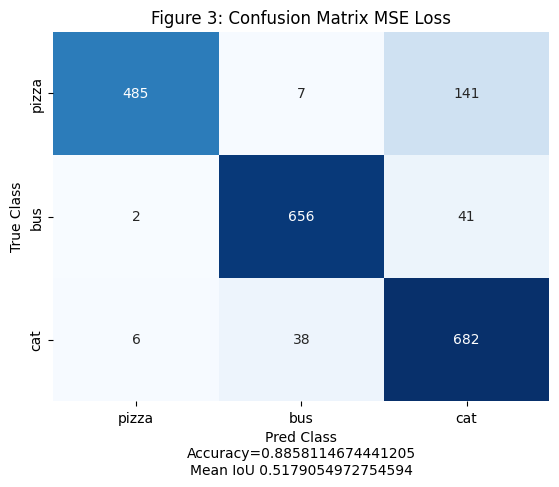

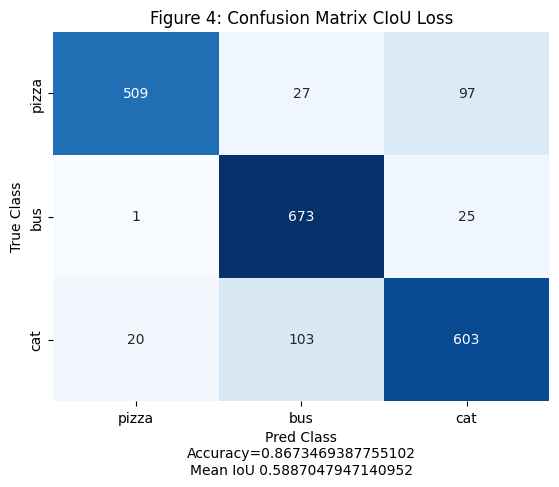

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def confusion_plot(lab, pred, ious, lossType, fignum):
    plt.figure()
    accuracy = np.sum(pred == lab) / len(pred)
    meanIous = np.sum(ious) / len(ious)
    conf1 = confusion_matrix(lab, pred)
    conf1 = pd.DataFrame(data = conf1, index=class_list, columns=class_list)
    ax1 = sns.heatmap(conf1, annot=True, cmap="Blues", fmt="d", cbar=False)
    ax1.set_title(f"Figure {fignum}: Confusion Matrix {lossType} Loss")
    ax1.set_ylabel("True Class")
    ax1.set_xlabel(f"Pred Class\nAccuracy={accuracy}\nMean IoU {meanIous}")
    return ax1

confusion_plot(mseLabels, msePred, mseIous, "MSE", 3)
confusion_plot(ciouLabels, ciouPred, ciouIous, "CIoU", 4)
plt.show()

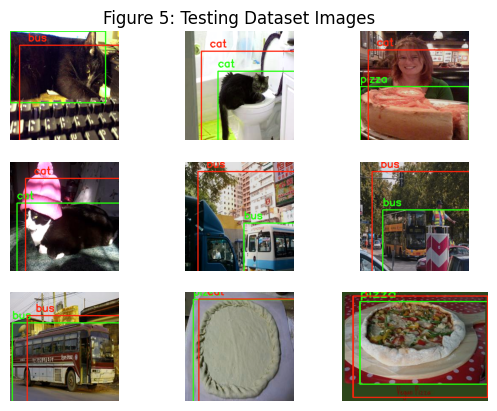

In [66]:
plt.figure()
fignum = 0
counts = {i: 0 for i, _ in enumerate(class_list)}

with torch.no_grad():
    modelCIoU.eval()
    device = torch.device('cuda')
    model.to(device)
    toPIL = tvt.ToPILImage()
    
    for data in valDataset:
        img, lbl, bbox = data
        if counts[lbl] == 3: continue
        counts[lbl] += 1
        fignum += 1

        img = torch.unsqueeze(img, 0)
        img = img.to(device)
        outCls, outBbox = modelCIoU(img)

        image = toPIL(img[0].cpu())
        image = np.array(image, dtype=np.uint8)
        
        [x, y, w, h] = (bbox * 256).astype(np.int32)
        image = cv2.rectangle(image, (x,y), (x+w, y+h), (36,255,12), 2)
        image = cv2.putText(image, class_list[lbl], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
        
        predLbl = np.argmax(outCls.cpu().numpy(), axis=1)[0]
        [x, y, w, h] = (outBbox[0].cpu() * 256).numpy().astype(np.int32)
        image = cv2.rectangle(image, (x,y), (x+w, y+h), (255,36,12), 2)
        image = cv2.putText(image, class_list[predLbl], (x+20, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,36,12), 2)

        ax = plt.subplot(3,3,fignum)
        plt.imshow(image)
        ax.set_axis_off()

        if fignum == 2:
            ax.set_title("Figure 5: Testing Dataset Images")
        if fignum > 9:
            break

plt.axis("tight")
plt.show()

My pizza detector has ok accuracy, but the bounding ox prediction could be better. 
Looking at the image results, it looks like the top left corner of the bounding box is in the same position every time. 
I was having some issues training with CIoU. My values were huge.
I tried experimenting with the learning rate and reduction options but it didn't help.
I reasoned that the MSE has a huge error when the values are so far off, so it blasts the residual head to get values in a decent range.
So I figured I would use MSE with CIoU on the first epoch so that my values were within a reasonable range.
This seemed to help my mean IoU a bit, but not enough to know if CIoU made that much of a difference. 

To improve my network, improving the bounding box prediction would be the first priority. 
I think it's possible the issue lies in that much of the spacial information is reduced, the resolution becomes 8x8 with deep features. 
This could be avoided if in the residual head, the resolution was somehow maintained.